# Benchmark: Postprocessing

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tueplots

In [2]:
from typing import List

In [3]:
from tueplots import bundles

In [4]:
palette_name = 'colorblind'
palette = [
    '#0173B2', '#DE8F05', '#029E73', '#D55E00', '#CC78BC', '#CA9161',
    '#FBAFE4', '#949494', '#ECE133', '#56B4E9'
]
mpl.rcParams.update({'axes.prop_cycle': mpl.cycler(color=palette)})

In [5]:
mpl.rcParams.update(bundles.icml2022_tex(column='full', nrows=3))

In [6]:
TASKS = [
    'CoLA', 'MRPC', 'RTE', 'SST2', 'STSB', 'WNLI', 'MNLI', 'MNLI-MM', 'QQP',
    'QNLI'
]

In [7]:
TASKS = [
    'CoLA', 'MRPC', 'QQP', 'SST2', 'STSB', 'WNLI', 'MNLI', 'MNLI-MM', 'RTE',
    'QNLI'
]

In [8]:
def plot(df: pd.DataFrame, cuda_memory_usage_limit: float = 16160 / 1024, tasks: List[str] = TASKS):
    ncols = min(2, len(tasks))
    nrows = (len(tasks) + 1) // 2
    fig, axs = plt.subplots(nrows, ncols, dpi=100, sharex=True, sharey=True)
    
    if ncols == 1:
        axs = np.array([[axs]])
    elif axs.ndim == 1:
        axs = axs[None, ...]

    frame = df \
        .reset_index(level=[0], drop=True) \
        .loc[tasks]
    xmin = frame.reset_index().batch.min() - 10
    xmax = frame.reset_index().batch.max() + 10

    for i, task in enumerate(tasks):
        if task not in frame.index:
            continue

        group = frame.loc[task]
        
        if any(['Baseline' not in group.index,
                'Randomized' not in group.index]):
            continue
        
        # Plot memory limit.
        ax = axs[i // 2, i % 2]
        ax.hlines([cuda_memory_usage_limit], [xmin], [xmax], 'red', 'dotted', label='Limit')

        # Plot baseline memory usage.
        baseline = group.loc['Baseline'] \
            .sort_index() \
            .reset_index()

        ax.plot(baseline.batch, baseline.cuda_memory_usage, '.-', label='No RMM')

        # Plot randomized matmul memory usage.
        randomized = group.loc['Randomized'] \
            .reset_index() \
            .set_index(['rate', 'batch']) \
            .sort_index(ascending=[False, True])
        
        rates = randomized \
            .reset_index() \
            .rate \
            .drop_duplicates() \
            .sort_values(ascending=False)
        
        for rate in rates:
            trend = randomized.loc[rate]
            label = f'{100 * float(rate):.0f}\%'
            ax.plot(trend.reset_index().batch, trend.cuda_memory_usage, '.-', label=label)
            
        # Configure axes.
        ax.grid(True)
        ax.legend()

    # Configure axes.
    for i in range(axs.shape[0]):
        axs[i, 0].set_ylabel('Memory Usage, GiB')

    for j in range(axs.shape[1]):
        axs[-1, j].set_xlabel('Batch Size')

    return fig

In [9]:
from math import isnan

In [10]:
def format_index(x) -> str:
    if isinstance(x, float):
        return 'No RMM'
    elif isinstance(x, str):
        rate = 100 * float(x)
        return f'{int(rate)}%'

In [208]:
mem = df \
    .loc[('RoBERTa')] \
    .reset_index() \
    .set_index(['task', 'batch', 'rate']) \
    .sort_index() \
    [['cuda_memory_usage', 'wall_time']] \
    .dropna() \
    .reset_index()
mem['wall_time'] = mem.wall_time / 60
mem.columns = ['Task', 'Batch', 'Rate', 'Mem', 'Time']
mem['Rate'] = mem.Rate.map(lambda x: format_index(x))
mem = mem.set_index(['Task', 'Batch', 'Rate'])

In [11]:
frames = []
keys = []
for task in TASKS:
    batch = max([x for x, _ in mem.loc[task].index.values])
    key = (task, batch)
    keys.append(key)
    frame = mem.loc[(task, batch)]
    frame['Factor'] = 100 * (1 - frame.Mem / frame.Mem.max())
    frames.append(frame)
tbl = pd.concat(frames, keys=keys, names=['Task', 'Batch']) \
    .sort_index(ascending=[True, True, False]) \
    .loc[['MRPC', 'QNLI', 'SST2']] \
    [['Mem', 'Factor']]
tbl['Mem'] = tbl.Mem.round(2)
tbl['Factor'] = tbl.Factor.round(1)#.apply(lambda x: f'{x:.1f}%')
tbl.columns = ['Mem, GiB', 'Saving, %']
tbl

NameError: name 'mem' is not defined

In [223]:
tbl.to_latex(buf='../../doc/randomized-backward/tbl/glue-memory-usage.tex',
             float_format=lambda x: f'{x:5.1f}')

In [12]:
df = pd.read_csv('../../data/benchmark-rmm.csv')
df[['model', 'opt', 'task', 'batch', 'rate']] = df.name.str.split('/', 4, expand=True)
df['batch'] = df.batch.astype(int)
df['cuda_memory_usage'] = df.cuda_memory_usage / 1024 ** 3
df['wall_time'] = df.wall_time * 1e-9
df = df \
    .drop(columns='name') \
    .set_index(['model', 'task', 'opt', 'batch']) \
    .sort_index()

In [13]:
print(TASKS[:6])
print(TASKS[6:])

['CoLA', 'MRPC', 'QQP', 'SST2', 'STSB', 'WNLI']
['MNLI', 'MNLI-MM', 'RTE', 'QNLI']


In [14]:
g = df.loc['RoBERTa'].loc['CoLA'].loc['Randomized'].reset_index().set_index(['rate', 'batch']) \
    .sort_index(ascending=[False, True])

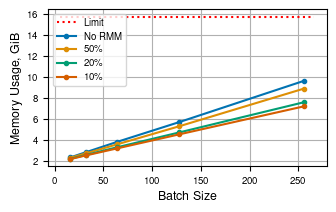

In [15]:
with mpl.rc_context(bundles.icml2022_tex(column='half', nrows=1)):
    fig = plot(df, tasks=TASKS[:1])
    fig.savefig('../../doc/rmm/fig/glue-memory-usage-cola.pgf')

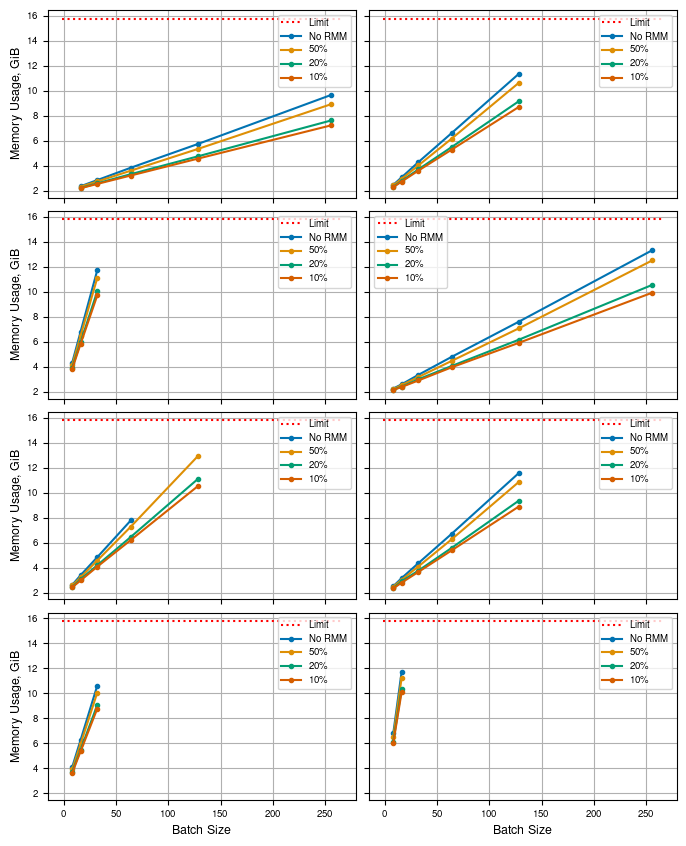

In [29]:
with mpl.rc_context(bundles.icml2022_tex(column='full', nrows=4)):
    fig = plot(df, tasks=TASKS[:6] + TASKS[-2:])
    fig.savefig('../../doc/rmm/fig/glue-memory-usage.pgf')